## **Model 17 (MobileNetV2 frozen base, train classifier head only)**

Model 13 (Dropout=0.3) is the best candidate to carry forward to the transfer learning comparison stage.

It has the highest test accuracy (0.9565).
Its loss values are lowest and most balanced across train/val/test.
It regularizes well (no heavy overfitting like BatchNorm-only or L2).

Dropout will also generalize better when you switch to pretrained architectures.

**IMG_SIZE → (224, 224) (instead of (128,128)) because MobileNetV2, ResNet50, EfficientNetB0 all expect (224,224,3) input.**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV2

# Use 224x224 for transfer learning
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

train_dir = "datasets/Training"
test_dir  = "datasets/Testing"

# Load datasets first (raw, no normalization yet)
raw_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=SEED
)

raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Save class names before mapping
class_names = raw_train_ds.class_names
NUM_CLASSES = len(class_names)
print("Classes:", class_names)

# Now split validation
val_size = int(0.2 * len(raw_train_ds))
val_ds = raw_train_ds.take(val_size)
train_ds = raw_train_ds.skip(val_size)

# Normalize
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x,y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x,y: (normalization_layer(x), y))
test_ds  = raw_test_ds.map(lambda x,y: (normalization_layer(x), y))

# Prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds   = val_ds.cache().prefetch(AUTOTUNE)
test_ds  = test_ds.cache().prefetch(AUTOTUNE)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


**Number of classes = inferred automatically from dataset**

In [6]:
NUM_CLASSES = len(class_names)

**Load MobileNetV2 base (frozen)**

In [7]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze base

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 8s 1us/step


**Build classifier head**

In [8]:
model17 = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

**Compile**

In [9]:
model17.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

**Callbacks**

In [10]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1),
    ModelCheckpoint("models/model17_best.h5", monitor="val_loss", save_best_only=True, verbose=1),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

**Train**

In [ ]:
history17 = model17.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    callbacks=callbacks
)

Epoch 1/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - accuracy: 0.7543 - loss: 0.6369
Epoch 1: val_loss improved from None to 0.28187, saving model to models/model17_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 70s 230ms/step - accuracy: 0.8271 - loss: 0.4570 - val_accuracy: 0.8979 - val_loss: 0.2819 - learning_rate: 0.0010
Epoch 2/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.8972 - loss: 0.2935
Epoch 2: val_loss improved from 0.28187 to 0.24522, saving model to models/model17_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 64s 222ms/step - accuracy: 0.9003 - loss: 0.2708 - val_accuracy: 0.9120 - val_loss: 0.2452 - learning_rate: 0.0010
Epoch 3/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.9155 - loss: 0.2303
Epoch 3: val_loss improved from 0.24522 to 0.22961, saving model to models/model17_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 62s 216ms/step - accuracy: 0.9218 - loss: 0.2121 - val_accuracy: 0.9137 - val_loss: 0.2296 - learning_rate: 0.0010
Epoch 4/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9299 - loss: 0.1824
Epoch 4: val_loss did not improve from 0.22961
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - accuracy: 0.9340 - loss: 0.1740 - val_accuracy: 0.9164 - val_loss: 0.2318 - learning_rate: 0.0010
Epoch 5/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.9419 - loss: 0.1536
Epoch 5: val_loss improved from 0.22961 to 0.21691, saving model to models/model17_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 204ms/step - accuracy: 0.9436 - loss: 0.1445 - val_accuracy: 0.9234 - val_loss: 0.2169 - learning_rate: 0.0010
Epoch 6/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9493 - loss: 0.1313
Epoch 6: val_loss did not improve from 0.21691
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 201ms/step - accuracy: 0.9530 - loss: 0.1245 - val_accuracy: 0.9181 - val_loss: 0.2491 - learning_rate: 0.0010
Epoch 7/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9567 - loss: 0.1209
Epoch 7: val_loss did not improve from 0.21691
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - accuracy: 0.9596 - loss: 0.1121 - val_accuracy: 0.9164 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 8/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.9569 - loss: 0.1121
Epoch 8: val_loss did not improve from 0.21691

Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - accuracy: 0.9622 - loss: 0.1005 - val_ac

286/286 ━━━━━━━━━━━━━━━━━━━━ 58s 202ms/step - accuracy: 0.9816 - loss: 0.0568 - val_accuracy: 0.9305 - val_loss: 0.1992 - learning_rate: 5.0000e-04
Epoch 11/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.9824 - loss: 0.0547
Epoch 11: val_loss improved from 0.19921 to 0.19565, saving model to models/model17_best.h5


286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 198ms/step - accuracy: 0.9856 - loss: 0.0470 - val_accuracy: 0.9366 - val_loss: 0.1957 - learning_rate: 5.0000e-04
Epoch 12/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9815 - loss: 0.0480
Epoch 12: val_loss did not improve from 0.19565
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 198ms/step - accuracy: 0.9840 - loss: 0.0437 - val_accuracy: 0.9340 - val_loss: 0.2423 - learning_rate: 5.0000e-04
Epoch 13/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9874 - loss: 0.0443
Epoch 13: val_loss did not improve from 0.19565
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 199ms/step - accuracy: 0.9899 - loss: 0.0378 - val_accuracy: 0.9393 - val_loss: 0.2098 - learning_rate: 5.0000e-04
Epoch 14/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9888 - loss: 0.0352
Epoch 14: val_loss did not improve from 0.19565

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 198ms/step - accuracy: 0.9904 - lo

286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 200ms/step - accuracy: 0.9908 - loss: 0.0293 - val_accuracy: 0.9401 - val_loss: 0.1934 - learning_rate: 2.5000e-04
Epoch 16/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9937 - loss: 0.0251
Epoch 16: val_loss did not improve from 0.19341
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 199ms/step - accuracy: 0.9948 - loss: 0.0225 - val_accuracy: 0.9384 - val_loss: 0.2050 - learning_rate: 2.5000e-04
Epoch 17/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.9907 - loss: 0.0252
Epoch 17: val_loss did not improve from 0.19341
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 200ms/step - accuracy: 0.9932 - loss: 0.0218 - val_accuracy: 0.9410 - val_loss: 0.2014 - learning_rate: 2.5000e-04
Epoch 18/20
286/286 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9945 - loss: 0.0248
Epoch 18: val_loss did not improve from 0.19341

Epoch 18: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
286/286 ━━━━━━━━━━━━━━━━━━━━ 57s 199ms/step - accuracy: 0.9956 - lo

**Best model**

In [12]:
best_model17 = tf.keras.models.load_model("models/model17_best.h5")

**Evaluate**

In [13]:
from eval import evaluate_model
# Evaluate Model 17
evaluate_model(best_model17, history17, test_ds, 
               model_name="Model 17 (MobileNetV2 frozen base)")


Model 17 (MobileNetV2 frozen base) - Test accuracy: 0.9428
Model 17 (MobileNetV2 frozen base) - Test loss: 0.1766
Model 17 (MobileNetV2 frozen base) - Final training accuracy: 0.9974
Model 17 (MobileNetV2 frozen base) - Final training loss: 0.0146
Model 17 (MobileNetV2 frozen base) - Final validation accuracy: 0.9428
Model 17 (MobileNetV2 frozen base) - Final validation loss: 0.2102


**Plot**

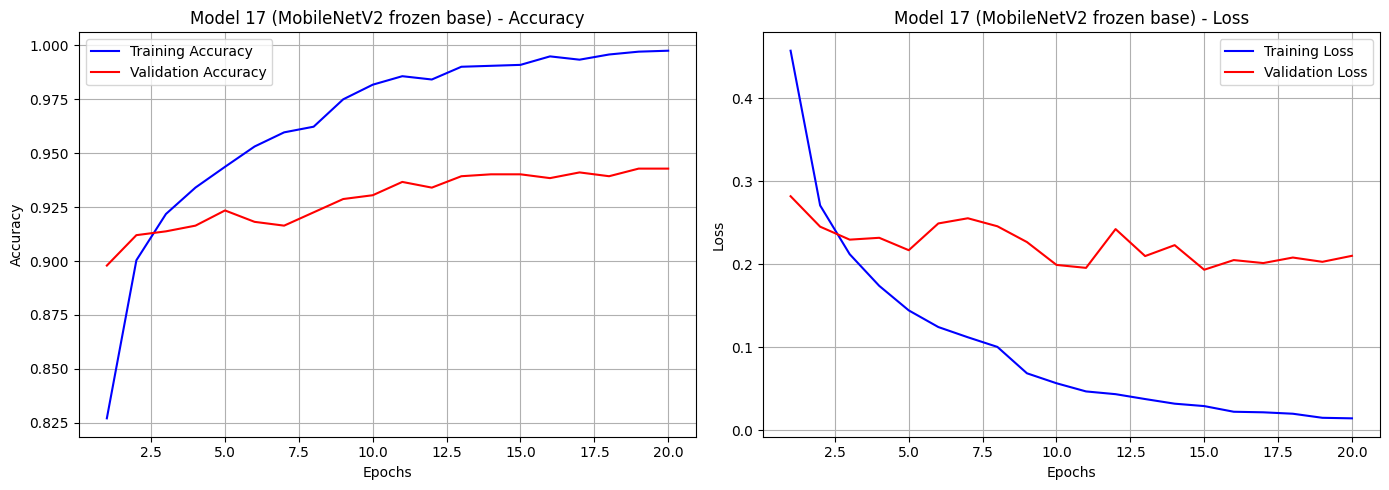

In [ ]:
from plot_utils import plot_training_curves
plot_training_curves(history17, 
                     model_name="Model 17 (MobileNetV2 frozen base)")

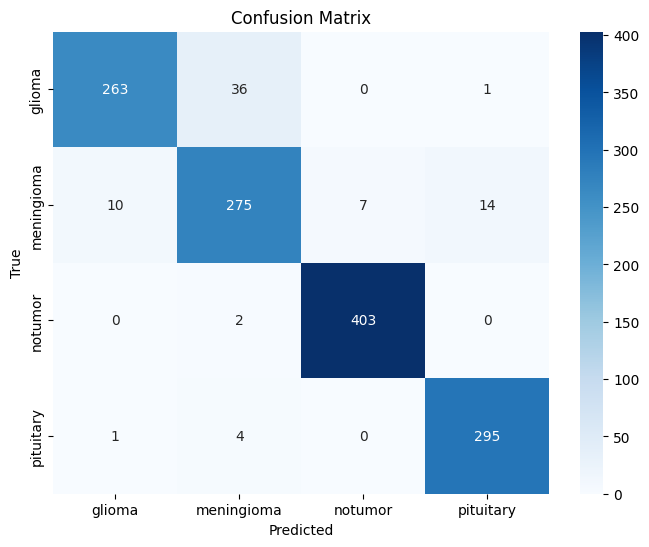


Classification Report:

              precision    recall  f1-score   support

      glioma       0.96      0.88      0.92       300
  meningioma       0.87      0.90      0.88       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.95      0.98      0.97       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [2]:
from plot_utils import (
    plot_training_curves,
    evaluate_model_with_confusion,
    plot_confusion_matrix_from_dataset
)

class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Confusion matrix with in-memory model
# evaluate_model_with_confusion(model19, test_ds, title="Confusion Matrix (Test)")

# Confusion matrix from saved model
plot_confusion_matrix_from_dataset("models/model17_best.h5", test_ds, class_names)
